## PyVBMC Toy Model

In this notebook we'll walk through how to solve a parameter estimation problem for a toy ODE problem. To get started, import all the packages we'll be needing:

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

In [2]:
def diffyqs(X, t, epsilon,beta): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = -beta*x - epsilon * x**3
    return [dx, dv]

def diffyqs_linear(X, t, beta): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = - beta*x
    return [dx, dv]

We'll also need an initial condition. This will remain the same for the rest of this problem since we're always looking at the same trajectory from the data.

In [3]:
# initial conditions (known from generation of data, or could get from data itself)
initial_condition = [0.0, 3.0]

To see odeint in action, let's generate the noise-free version of this data (since we know the true parameter values we can cheat).

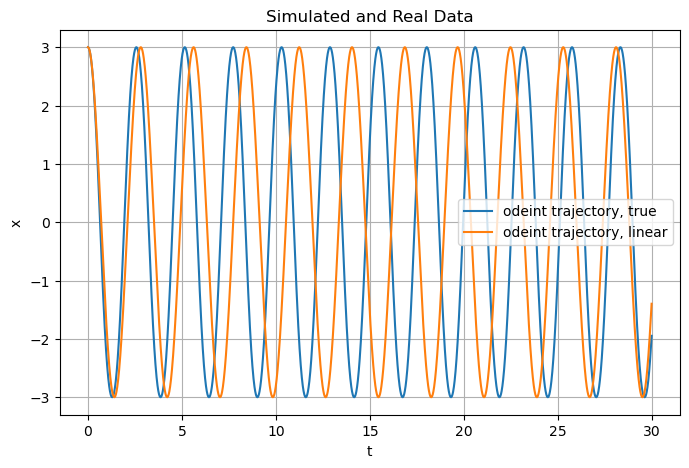

In [4]:
epsilon = 0.8
beta = 5
t = np.arange(0,30,0.01)

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta)) # pass odeint the differential equation, initial condition, time array, and parameters
sol_linear = odeint(diffyqs_linear, initial_condition, t, args=(beta,)) # pass odeint the differential equation, initial condition, time array, and parameters

# plot plot plot
plt.figure(figsize=(8,5))
#plt.plot(t,x_true, label = 'true data')
plt.plot(t,sol.T[1], label = 'odeint trajectory, true') # to get the right part of the solution you have to do this weird transpose index thing
plt.plot(t,sol_linear.T[1], label = 'odeint trajectory, linear')
plt.title('Simulated and Real Data')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

x_true = sol.T[1]

In [7]:
def log_likelihood(theta):
    beta = theta # unpack parameters from theta

    sol = odeint(diffyqs_linear, initial_condition, t, args=(beta,)) # get solution of ODE with current choice of params
    
    return np.sum( -(sol.T[1] - x_true)**2) # normal distribution


D = 1 

prior_mu =  np.full((1,D), 5.0) # Mean of the prior (in theory, I think rn this is just being used to get PLB, PUB)  #np.zeros((1, D))
prior_std = 3 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
UB = np.full((1, D), 20.0)  # Upper bounds (picked to be reasonable)

PLB =  prior_mu - prior_std  # Plausible lower bounds     # PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  prior_mu + prior_std  # Plausible upper bounds     # PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)

x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))

In [6]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


ValueError: ('setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.', 'FunctionLogger:FuncError Error in executing the logged functionwith input: [5.]')

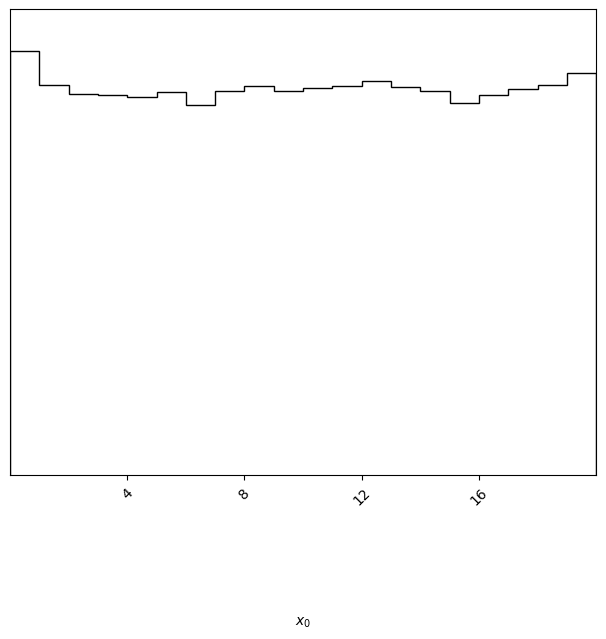

In [85]:
vp.plot();

Sampling the posterior lets us find values of interest like the mean values of posterior:

In [86]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [9.99413686]


We can use these mean values with odeint to produce a new trajcetory and see how good PyVBMC did:

In [8]:
beta = post_mean[0]

sol = odeint(diffyqs_linear, initial_condition, t, args=(beta,))

plt.figure(figsize=(8,5))
plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

NameError: name 'post_mean' is not defined

In [88]:
def log_likelihood(theta):
    beta, v0 = theta # unpack parameters from theta

    sol = odeint(diffyqs_linear, [v0, 2.5], t, args=(beta,)) # get solution of ODE with current choice of params
    
    return np.sum( -(sol.T[1] - x_true)**2) # normal distribution

D = 2

prior_mu =  np.full((1,D), 5.0) 
prior_std = 3 * np.ones((1, D)) 

LB = np.full((1, D), 0.0) 
LB[0][1] = -4 ## initial velocity has different possible range of values
UB = np.full((1, D), 20.0)  
UB[0][1] = 4

PLB =  prior_mu - prior_std  # Plausible lower bounds
PUB =  prior_mu + prior_std  # Plausible upper bounds
PLB[0][1] = -2
PUB[0][1] = 2

x0 = np.copy(prior_mu) # starting point 
x0[0][1] = 0.5

In [89]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB))

vp, results = vbmc.optimize();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -32854.09      9329.94 153513874521317.09        2        inf     start warm-up
     1         15         557.31        58.66      8969.73        2        inf     
     2         20       -3137.00      1356.01      2639.11        2    7.9e+04     
     3         25        -268.99      1042.43     26716.40        2   6.43e+05     
     4         30        -492.17         1.00       161.74        2   4.56e+03     
     5         35        -494.59         0.00         0.80        2         27     
     6         40        -494.56         0.01         0.01        2      0.448     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 5. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 6. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


     7         45        -494.59         0.00         0.00        2      0.109     
     8         50        -494.57         0.00         0.00        2      0.115     
     9         55        -494.59         0.00         0.00        2      0.118     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    10         60        -494.62         0.00         0.00        2      0.124     end warm-up
    11         65        -494.67         0.00         0.08        2       2.08     
    12         70        -495.65         0.01         0.53        2       15.8     
    13         75        -494.68         0.00         0.35        3       11.6     
    14         80        -494.74         0.00         0.10        4        2.5     
    15         85        -494.67         0.00         0.11        4       2.77     
    16         90        -494.76         0.00         0.12        5        3.2     
    17         95        -494.76         0.00         0.22        5       5.19     
    18        100        -495.16         0.00         0.22        5       6.53     
    19        105        -494.64         0.00         0.42        5       11.6     
    20        110        -494.94         0.00         0.16        6       4.68     
    21        115        -494.86         0.00         0.11       

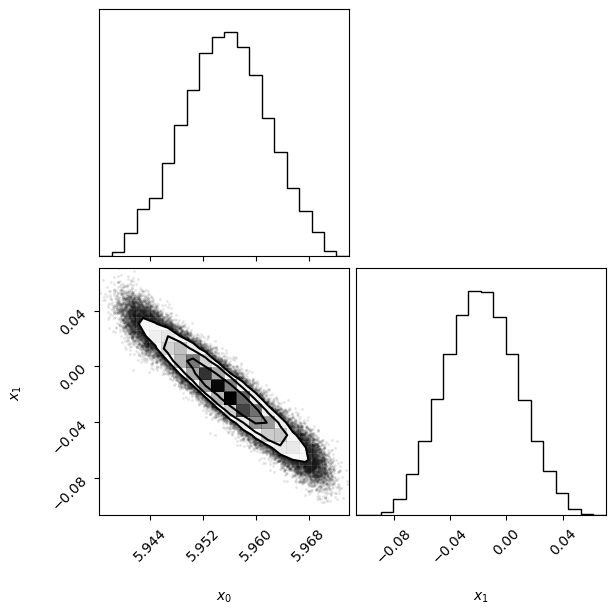

In [90]:
vp.plot();

The approximate posterior mean is: [ 5.95538729 -0.01774874]


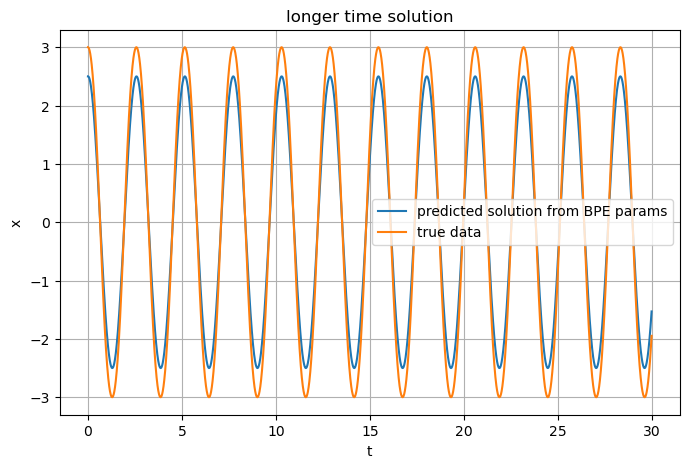

In [92]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


beta =  post_mean[0]
v0 = post_mean[1]

sol = odeint(diffyqs_linear, [v0,2.5], t, args=(beta,))

plt.figure(figsize=(8,5))
plt.title("longer time solution")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()